# Determining the most promising targets in Gerosa

Based on their number of highly correlated genes.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 
from scipy.stats import spearmanr
from pyvis.network import Network

In [2]:
#import self-made functions
%run '/Users/mariekececilia/Documents/master_thesis_code/methods.ipynb'

In [3]:
#figure saving settings for this Notebook
folder_path_figures = 'Figures/'
figure_format = 'pdf'

## Load, clean and prepare data:

In [4]:
#load data
gexp_g, flux_g = load_gerosa()

#remove duplicated genes
gexp_g, gexp_g_groups = clean_gexp_g(gexp_g)

#remove constant, duplicated, and external reactions + reactions with many null entries
flux_g, flux_g_groups = clean_gerosa(flux_g)

#Convert fluxes to absolute fluxes because amount of required enzyme is independent of flux direction
flux_g = flux_g.abs()

## Calculate all correlations

In [5]:
corr = get_all_correlations(gexp_g, flux_g, column_names = ['gene', 'reaction', 'r'])

In [6]:
#calculate absolute correlations
corr_abs = corr.copy()
corr_abs['r'] = corr_abs['r'].abs()

#sort pairs by correlation rank and then alphabetically by reaction
corr_abs = (corr_abs
            .sort_values(['r', 'reaction'], ascending = [False, True])
            .reset_index(drop = True)) 

#Define highly correlated genes
threshold = 0.9

### Effect of removed gene duplicates

In [7]:
for gene in gexp_g_groups:
    display(corr_abs[(corr_abs['gene'] == gene) & (corr_abs['r'] > threshold)].sort_values(by = 'r', ascending = False))

,gene,reaction,r


,gene,reaction,r


,gene,reaction,r


,gene,reaction,r


,gene,reaction,r


,gene,reaction,r


,gene,reaction,r


,gene,reaction,r


,gene,reaction,r


--> None of the genes that were duplicated (had exact same measurments as others) correlate with any target above the threshold, so their removal did not change the number of highly correlated genes for any reaction.

## Network of highly correlated gene-reaction pairs

In [8]:
def build_network(data, threshold):

    net = Network(directed=False, notebook=True, height='800px', width='1200px')

    for _, gene, reaction, r in data.itertuples():
        if r > threshold:
            net.add_node(gene, shape='circle')
            net.add_node(reaction, shape='box', color='red')
            net.add_edge(gene, reaction, color='green')
        if r < -threshold:
            net.add_node(gene, shape='circle')
            net.add_node(reaction, shape='box', color='red')
            net.add_edge(gene, reaction, color='red')
    return net

In [9]:
net = build_network(corr, threshold)
net.show_buttons(filter_ = ['physics'])
net.show(folder_path_figures + 'network_gerosa_corr.html');

## Number of highly correlated gene-reaction pairs

'corr_abs' is already sorted by absolute correlation, but here the correlations are grouped by reaction and correlation coefficient since several genes correlate to the same reaction by  the same degree. This makes it easier to identify the reactions that correlate with one or several genes by the highest degrees in Gerosa. 

In [10]:
grouped_df = (corr_abs.groupby(['r','reaction'], as_index=False)
              .size()
              .rename(columns = {'size':'gene_count'})
              #.reset_index(name='gene_count') #can use this instead of as_index = False and .rename()
              .drop_duplicates()
              #.sort_values(['r','reaction'], ascending = [False, True]) #sort reaction level alphabetically 
              .sort_values(['r','gene_count'], ascending = [False, False]) #sort reaction level by counts
              .reset_index(drop = True)
)

display(grouped_df.head(20))

,r,reaction,gene_count
0,1.00000,R_PPC,8
1,1.00000,R_AKGDH,5
2,1.00000,R_ICDHyr,3
3,1.00000,R_ACONTa,1
4,1.00000,R_G6PDH2r,1
5,1.00000,R_PDH,1
6,1.00000,R_RPE,1
7,1.00000,R_TALA,1
8,1.00000,R_TKT2,1
9,0.97619,R_ICDHyr,30


### The perfect correlations

In [11]:
#aggregated, showing the genes:
display(corr_abs.query('r == 1')
        .groupby('reaction')
        .agg({'gene':set})
        .sort_index()
        .style.set_properties(subset=['gene'], **{'width': '200px'})
       )

,gene
reaction,
R_ACONTa,{'b3484'}
R_AKGDH,"{'b1535', 'b2064', 'b1432', 'b3935', 'b2506'}"
R_G6PDH2r,{'b3623'}
R_ICDHyr,"{'b1973', 'b1790', 'b2380'}"
R_PDH,{'b1579'}
R_PPC,"{'b3301', 'b0180', 'b1286', 'b2046', 'b3306', 'b3565', 'b1281', 'b2330'}"
R_RPE,{'b0532'}
R_TALA,{'b0532'}
R_TKT2,{'b0532'}


### Number above threshold

To differentiate between reactions that all are invovled in the strongest correlated gene-reaction pairs. 

In [12]:
#extract pairs above treshold
high_corr = corr_abs[corr_abs['r'] > threshold]
high_corr = high_corr.sort_values(['r', 'reaction'], ascending = [False, True])

#count occurenses
high_corr_occurrence = (high_corr.groupby(['reaction'], as_index=False)
                          .size()
                          .rename(columns = {'size':'gene_count'}) 
                          #.reset_index(name='gene_count') #can use this instead of as_index = False and .rename()
                          #.sort_values('reaction') #sort reactions alphabetically 
                          .sort_values(['gene_count', 'reaction'], ascending = [False, True]) #sort by counts and then alphabetically
                          .reset_index(drop = True)
)
#show results
print('Treshold:', threshold)
display(high_corr_occurrence)

Treshold: 0.9


,reaction,gene_count
0,R_PPC,192
1,R_ICDHyr,164
2,R_AKGDH,129
3,R_ACONTa,106
4,R_PDH,105
5,R_ICL,27
6,R_RPI,20
7,R_ENO,18
8,R_GAPD,18
9,R_FUM,15


## Promising targets

### Candidates

Choosing candidates that both have perfect correlations *and* have the most correlated genes above a threshold in general (to differentiate between all with the perfect correlation)

In [13]:
#(most) perfect correlations
only_perfect = len(grouped_df.query('r == 1 & gene_count >=1')) #adjust gene_count for stricter selection of promising targets
set_high = set(grouped_df.iloc[0:only_perfect]['reaction'].tolist())
print('Form (most) pair(s) with perfect correlation (random order):\n', set_high)

#most correlations above a treshhold
set_max = set(high_corr_occurrence.iloc[0:4]['reaction'].tolist())
print('\nForm most pairs with correlation above %s (random order):\n' % threshold, set_max)

#included in both
candidates =  (set_high & set_max)
print('\nCandidates in random order (present in both above lists):\n', candidates)

Form (most) pair(s) with perfect correlation (random order):
 {'R_PDH', 'R_ICDHyr', 'R_ACONTa', 'R_G6PDH2r', 'R_TKT2', 'R_TALA', 'R_RPE', 'R_AKGDH', 'R_PPC'}

Form most pairs with correlation above 0.9 (random order):
 {'R_ICDHyr', 'R_AKGDH', 'R_PPC', 'R_ACONTa'}

Candidates in random order (present in both above lists):
 {'R_ACONTa', 'R_AKGDH', 'R_ICDHyr', 'R_PPC'}


## Chosen targets

In [14]:
chosen_targets = ['R_PPC', 'R_AKGDH', 'R_ICDHyr'] #top three in both number of perfect correlations and number of high correlations

Alternative reactions (those removed earlier because they are duplicates):

In [15]:
for candidate in sorted(chosen_targets): 
    if candidate in flux_g_groups: 
        print(candidate, '– alternatively:', sorted(flux_g_groups[candidate])) 
    else:
        print (candidate, '– no duplicates')

R_AKGDH – alternatively: ['R_SUCOAS']
R_ICDHyr – no duplicates
R_PPC – no duplicates


### Flux of chosen targets

In [16]:
display(np.round(flux_g[sorted(chosen_targets)],3))
display(np.round(flux_g[sorted(chosen_targets)].describe(),3))

,R_AKGDH,R_ICDHyr,R_PPC
Acetate,4.267,4.696,1.774
Fructose,3.875,4.566,3.546
Galactose,0.236,0.496,0.377
Glucose,2.138,2.978,2.453
Glycerol,1.840,2.465,1.376
Gluconate,0.182,1.154,1.943
Pyruvate,7.416,7.979,2.489
Succinate,2.352,3.039,2.016


,R_AKGDH,R_ICDHyr,R_PPC
count,8.000,8.000,8.000
mean,2.788,3.422,1.997
std,2.378,2.350,0.919
min,0.182,0.496,0.377
25%,1.439,2.137,1.675
50%,2.245,3.008,1.980
75%,3.973,4.599,2.462
max,7.416,7.979,3.546


### Highly correlated genes of chosen targets

The genes with the highest aboslute correlations to the targets and their CoV:

In [17]:
for candidate in sorted(chosen_targets):
    #find all correlations with target and sort them by absolute value
    res = (corr_abs[corr_abs['reaction'] == candidate].sort_values(by = 'r', ascending = False).reset_index(drop = True))
    #calculate their cov
    cov = np.round(gexp_g[res['gene']].std()/gexp_g[res['gene']].mean(),4)
    #add cov as a columns
    res['CoV'] = res['gene'].map(lambda x: cov[x])
    #display results
    print('Intereseting genes when target = %s:' % candidate[2:])
    display(res.head(15)[['gene', 'r', 'CoV']])

Intereseting genes when target = AKGDH:


,gene,r,CoV
0,b1432,1.00000,0.5473
1,b2064,1.00000,0.3942
2,b2506,1.00000,0.8195
3,b3935,1.00000,0.3366
4,b1535,1.00000,0.4249
5,b2318,0.97619,0.3656
6,b3532,0.97619,0.2058
7,b3484,0.97619,0.4882
8,b3376,0.97619,0.5364
9,b2865,0.97619,0.1832


Intereseting genes when target = ICDHyr:


,gene,r,CoV
0,b1790,1.00000,0.6116
1,b2380,1.00000,0.5066
2,b1973,1.00000,0.4212
3,b3594,0.97619,0.4137
4,b2642,0.97619,0.4698
5,b2968,0.97619,0.4601
6,b3074,0.97619,0.7419
7,b3333,0.97619,0.6198
8,b3550,0.97619,0.4491
9,b3935,0.97619,0.3366


Intereseting genes when target = PPC:


,gene,r,CoV
0,b0180,1.00000,0.1932
1,b1286,1.00000,0.3958
2,b2046,1.00000,0.2811
3,b2330,1.00000,0.1743
4,b3301,1.00000,0.2634
5,b3306,1.00000,0.2882
6,b3565,1.00000,0.3283
7,b1281,1.00000,0.4522
8,b3636,0.97619,0.4003
9,b3303,0.97619,0.2667


### Perfect correlated genes of chosen targets

Perfect correlations with AKGDH:


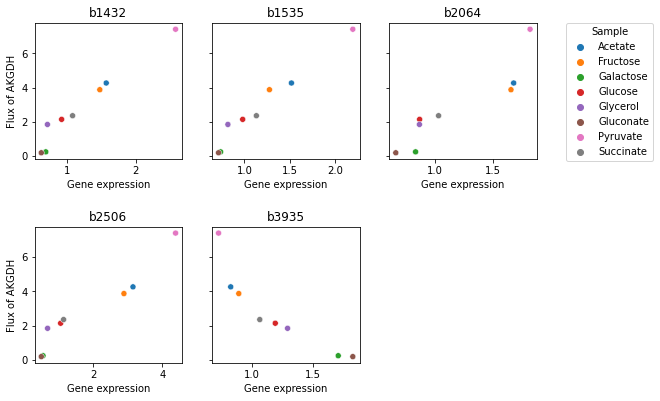

Perfect correlations with ICDHyr:


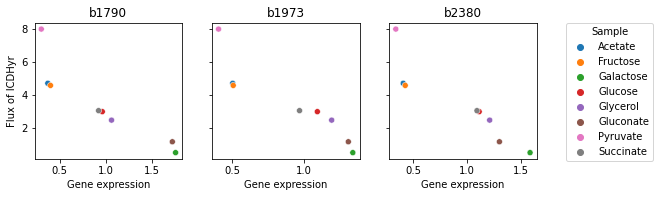

Perfect correlations with PPC:


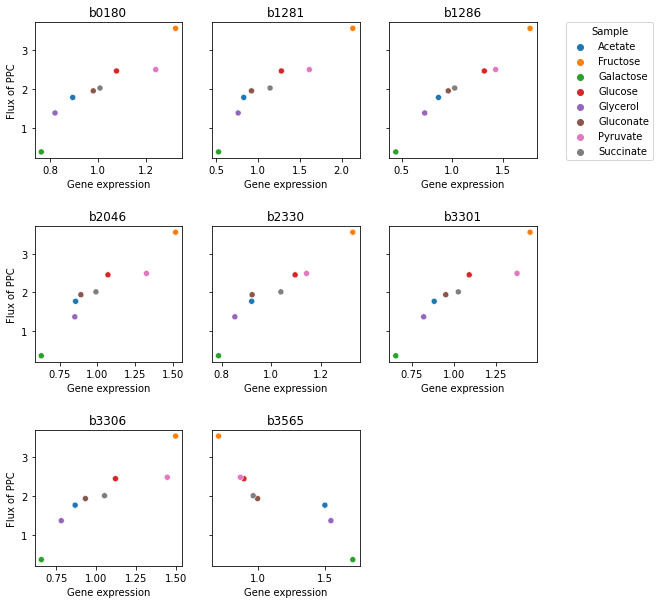

In [18]:
for candidate in sorted(chosen_targets):
    figure_name = 'perfect_correlated_genes_vs_' + candidate[2:]
    suptitle = 'Perfect correlations with %s:' % candidate[2:]
    print(suptitle)
    
    #find all genes with perfect correlations with target
    res = corr_abs[corr_abs['reaction'] == candidate]
    res = res.query('r == 1')['gene'].tolist()
    
    #plot their flux
    #what to plot
    data = gexp_g[res].copy()
    y_col = candidate
    data[y_col] = flux_g[candidate]  #extract flux data of the target  
    plot_order = sorted(res)    
    #settings
    hue = 'Sample'
    data[hue] = data.index    
    palette = 'tab10' 
    nrows = 3
    ncols = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9,10), sharex = False, sharey = True)    
    for gene, ax in zip(plot_order, fig.axes):
        ax = sns.scatterplot(x=gene, y=y_col, data=data, ax = ax,  hue = hue, palette = palette)
        
        #store legend for later and remove it
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()
        
        #set tiltes and labels
        ax.set_ylabel('Flux of %s' % candidate[2:])
        ax.set_xlabel('Gene expression')
        ax.set_title(gene)        
    
    #remove empty subplots from grid
    nplots = len(plot_order)
    remove_empty_subplots(fig, axes, nplots, nrows, ncols)
    plt.subplots_adjust(wspace=0.2, hspace=0.5) #width and height between subplots

    #add common legend and title
    axes[0][min(ncols-1, nplots-1)].legend(handles, labels, 
               loc = 'upper left',
               bbox_to_anchor= (1.2, 1),
               borderaxespad=0.,
               ncol=1 ,
               title = hue,
              )
    #plt.suptitle(suptitle, fontweight = 'bold')
    
    #save figure
    plt.savefig(('%s%s.%s' % (folder_path_figures, figure_name, figure_format)),
                format=figure_format, 
                dpi=200,
                facecolor = 'white',
                bbox_inches='tight', #include the legend 
             )
    plt.show()
    plt.close()